<a href="https://colab.research.google.com/github/MLMario/mariogj1987/blob/main/ITSA_for_casual_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Causal Inference in Time Series: A Simple Demonstration Using Interrupted Time Series Analysis



## Introduction

In the realm of causal inference, determining the effect of an intervention in a time series can be quite challenging, especially when randomized controlled trials are not feasible. This notebook aims to provide a straightforward demonstration of a quasi-experimentation method called Interrupted Time Series Analysis (ITSA) that can be employed to infer causal effects in time series data. To illustrate this, we will simulate two scenarios wherein a freight broker company experiences a drop in demand subsequent to a strategic price change (One scenario with autocorrelation and another without).

Before starting though, lets discuss a bit what ITSA is as well as it's strenghts and limitations. (For a good discussion on the method you can review [this paper](https://pubmed.ncbi.nlm.nih.gov/24268083/)



## What is ITSA?

Interrupted Time Series Analysis (ITSA) is a quasi-experimental research design that leverages time series data to evaluate the potential causal effect of interventions or treatments. The method hinges on examining changes in the levels and trends of an outcome variable before and after a specific "interruption" or intervention is introduced. This "interruption" is typically a policy change, program introduction, or any event of interest. By contrasting the observed post-intervention data with what might have been expected had the intervention not occurred (based on pre-intervention trends), ITSA can provide insights into the immediate and longer-term effects of the intervention. It's particularly valuable in scenarios where randomized controlled trials are not feasible, offering a robust alternative to infer causality from observational data.




## ITSA Strenghts and Limitations

It can be used when we don't have access to a Randomize Control Trial and It's suitable to detect changes in level and slope of the time series data at a time of intervention or natural event, to do this though, we at least need 8 pre-intervations data points and 8 post-intervention data points, this could potentially translate to un-feasable business timelines.

This is also a good framework to identify overall, aggregated changes in population, but it's not capable of accounting for individual bias, additionally, it can hide the effect of an intervention in a sub-group of the population in study. It's always important to sudivide the and ITSA and repeat in all subgroups where an intervention could have had a different impact.

Other limitation is that this method cannot account for external factors that might have happened at the time of intervention nor it can account for non-linear trends.

Lastly, this method does not account for how to deal with autocorrelation in the time series, thankfully there are several ways we can try to account for this. Since autocorrelation is a common feature in time series data, we will review a few options with a second example.

All of this is important when evaluating if an ITSA is or not suitable for your casual inference case.



## Example 1: Demand drop due to a price in change.  

**Context:**
XYZ Freight Brokers Inc. is a leading freight broker company facilitating large shipments across routes. They implemented a company-wide price change. The objective is to understand the impact on demand from shippers.

### Step 1: Generate Synthetic Data

In [51]:
# Setting seed for reproducibility
np.random.seed(42)

# Define parameters
n_months_pre = 18
n_months_post = 6
n_months_total = n_months_pre + n_months_post

# Generate time variable
time = np.arange(n_months_total)

# Generate synthetic demand
baseline_demand = 1000 + 10 * time
noise = np.random.normal(0, 50, n_months_total)
intervention_effect = -200
post_intervention_trend = 10
demand = baseline_demand + noise
demand[n_months_pre:] += intervention_effect + post_intervention_trend * (time[n_months_pre:] - n_months_pre)

# Convert to dataframe for easier analysis
df = pd.DataFrame({
    'Time': time,
    'Demand': demand,
    'Intervention': [0 if i < n_months_pre else 1 for i in range(n_months_total)],
    'TimeAfterIntervention': [0 if i < n_months_pre else i - n_months_pre + 1 for i in range(n_months_total)]
})

df.head()

,Time,Demand,Intervention,TimeAfterIntervention
0,0,1024.835708,0,0
1,1,1003.086785,0,0
2,2,1052.384427,0,0
3,3,1106.151493,0,0
4,4,1028.292331,0,0


### Step 2: Visualize the Data

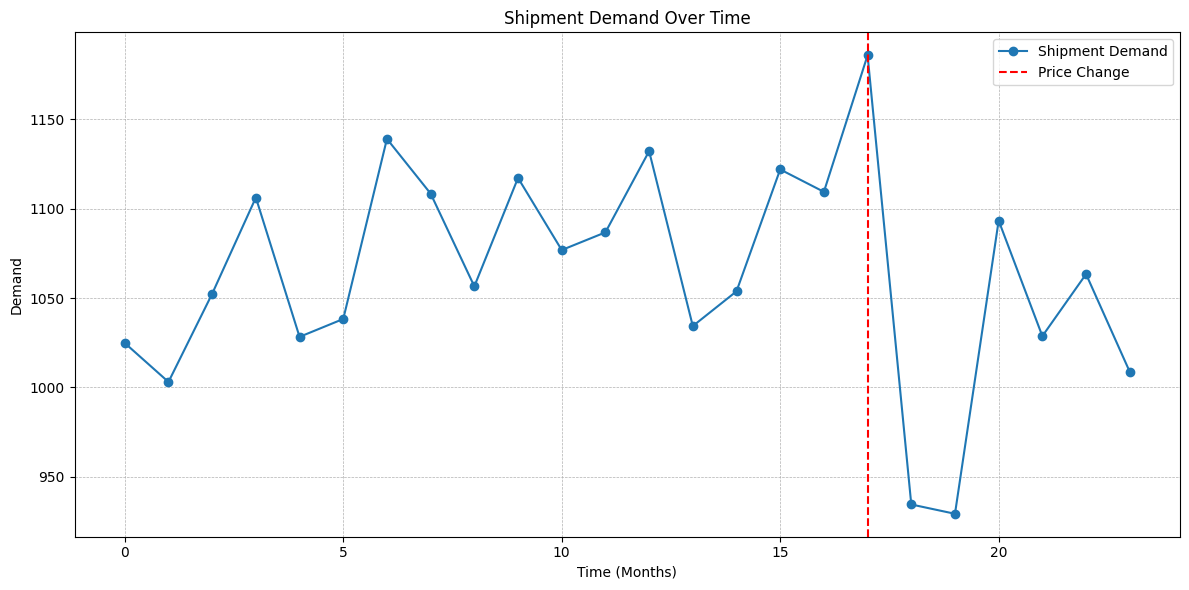

In [52]:
# Plotting the demand over time
plt.figure(figsize=(12, 6))
plt.plot(df['Time'], df['Demand'], label='Shipment Demand', marker='o', linestyle='-')
plt.axvline(n_months_pre - 1, color='red', linestyle='--', label='Price Change')
plt.title('Shipment Demand Over Time')
plt.xlabel('Time (Months)')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Step 3: Perform ITSA using Segmented Regression

We'll now fit a segmented regression model to this data to quantify the immediate effect (change in level) and the trend change post-intervention.

The model is:

Demand = B0 + B1 * Time + B2 * Intervention + B3 * TimeAfterIntervention + Error


In [53]:
# Building the segmented regression model
X = df[['Time', 'Intervention', 'TimeAfterIntervention']]
X = sm.add_constant(X)
y = df['Demand']

model = sm.OLS(y, X).fit()

# Displaying regression results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Demand   R-squared:                       0.510
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     6.943
Date:                Wed, 20 Sep 2023   Prob (F-statistic):            0.00219
Time:                        17:08:36   Log-Likelihood:                -123.71
No. Observations:                  24   AIC:                             255.4
Df Residuals:                      20   BIC:                             260.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1037.4385     20.776     49.934      0.000     994.100    1080.777
Time                      5.2341      2.086      2.509      0.021       0.882       9.586
Intervention           -187.5552     47.533     -3.946      0.001    -286.707     -88.403
TimeAfterIntervention    15.0008     11.174      1.342      0.194      -8.308      38.310
==============================================================================
Omnibus:                        0.994   Durbin-Watson:                   2.224
Prob(Omnibus):                  0.608   Jarque-Bera (JB):                0.969
Skew:                           0.397   Prob(JB):                        0.616
Kurtosis:                       2.418   Cond. No.                         69.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Here are the results from the segmented regression:

- **Intercept (B0):** The starting demand (when time is 0 and before the intervention) is approximately 1037.4 units.

- **Time (B1):** For each month before the intervention, the demand increases by around 5.23 units.

- **Intervention (B2):** Right after the intervention (price change), there's an immediate drop of approximately 187.6 units in demand.

- **Time After Intervention (B3):** Post-intervention, for each subsequent month, the demand increases by approximately 15 units. However, this coefficient is not statistically significant at the 5% level (p-value = 0.194).

**Interpretation:**

- The immediate drop in demand after the price change is significant and is about 187.6 units.

- Although the demand trend seems to increase post-intervention, this increase isn't statistically significant, suggesting that we don't have strong evidence to claim a change in trend post-intervention.

## Example 2: Demand Drop due to a price change w/autocorrelation and a growing trend in the TS data

This example aims to provide a demonstration of how Interrupted Time Series Analysis (ITSA) can be employed in the presence of auto-correlation to infer causal effects. Using a simulated scenario, we'll analyze the impact of a strategic price change on the shipment demand of a freight broker company, while accounting for auto-correlation in the data.

For simplicity,we will use the simple method of including a lag variable in the data, but other methods can also be evaluated, the ones I'm familiar with are:

**1) Lagged Variables:** Incorporate lagged values of the dependent variable as predictors in the regression model. This can help account for patterns from previous time points that might be influencing the current observation.


**2) ARIMA (AutoRegressive Integrated Moving Average) Models:** These models combine differencing with autoregression and a moving average component. Just like the the lagged variable method, this method is designed to handle auto-correlated data with additional regressors and can be used in an ITSA framework.

**3) Generalized Estimating Equations (GEE):** GEE is a regression technique that can be used with time series data and allows for specifying an auto-correlation structure, ensuring that standard errors are robust to the presence of auto-correlation.

**4) Newey-West Standard Errors:** In cases of heteroskedasticity and auto-correlation, Newey-West standard errors can be used to produce robust standard errors.

### Step 1: Generate Synthetic Data with Auto-correlation


In [54]:

# Define parameters for AR(1) process
alpha = 1000
rho = 0.2
intervention_effect = -500
post_intervention_trend = 10
np.random.seed(42)
trend_effect = 50 # Parameters for the growing trend
post_intervention_trend = 0

# Define time parameters
n_months_pre = 36
n_months_post = 6
n_months_total = n_months_pre + n_months_post

# Generate time variable
time = np.arange(n_months_total)

# Initialize the demand array
demand_ar_trend = np.zeros(n_months_total)

# Initial demand value
demand_ar_trend[0] = alpha + np.random.normal(0, 100)

# Generate AR(1) process for demand with a growing trend
for t in range(1, n_months_total):
    demand_ar_trend[t] = alpha + rho * demand_ar_trend[t-1] + trend_effect*t + np.random.normal(0, 100)

# Introduce intervention effect (drop post price change)
demand_ar_trend[n_months_pre:] += intervention_effect + post_intervention_trend * (time[n_months_pre:] - n_months_pre)

# Convert to dataframe for easier analysis
df_ar_trend = pd.DataFrame({
    'Time': time,
    'Demand': demand_ar_trend,
    'Intervention': [0 if i < n_months_pre else 1 for i in range(n_months_total)],
    'TimeAfterIntervention': [0 if i < n_months_pre else i - n_months_pre + 1 for i in range(n_months_total)]
})





### Step 2: Visualize the data

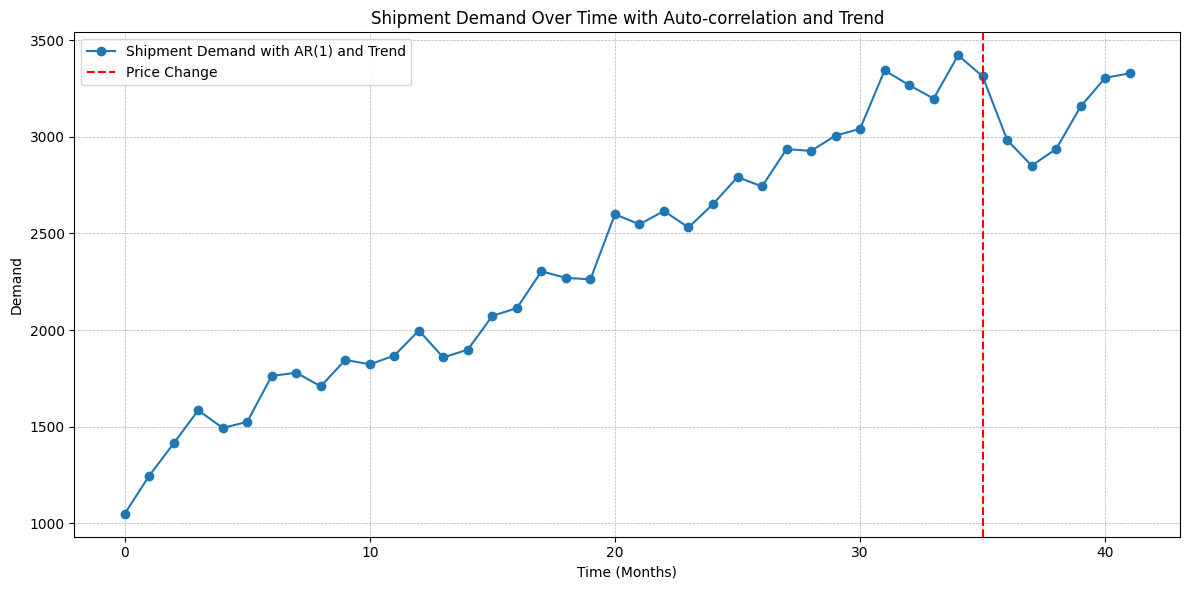

In [55]:

# Plotting the AR(1) demand data with a trend
plt.figure(figsize=(12, 6))
plt.plot(df_ar_trend['Time'], df_ar_trend['Demand'], label='Shipment Demand with AR(1) and Trend', marker='o', linestyle='-')
plt.axvline(n_months_pre - 1, color='red', linestyle='--', label='Price Change')
plt.title('Shipment Demand Over Time with Auto-correlation and Trend')
plt.xlabel('Time (Months)')
plt.ylabel('Demand')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### Step 3: Evaluate Autocorrelation

Now, lets make a quick analysis to judge or not if there is any autocorrelation in the data. We will do:

**1) Durbin-Watson Statistic:** The Durbin-Watson tests for the presence of autocorrelation in the residuals of a regression analysis. Its value ranges from 0 to 4. A value close to 2 suggests no autocorrelation, while values approaching 0 indicate positive autocorrelation and values towards 4 indicate negative autocorrelation

**2) Partial Autocorrelation:** The Partial Autocorrelation provides insights into the relationship between an observation and its lags, discounting the relationships of intervening observations. In other words, it gives the partial correlation of a time series with its own lagged values, controlling for the values of the time series at all shorter lags.

In [56]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(df_ar_trend['Demand'])
print(f'DW stats value is: {dw_stat:.4f} which is close to 0, suggesting strong positive autocorrelation')

DW stats value is: 0.0033 which is close to 0, suggesting strong positive autocorrelation


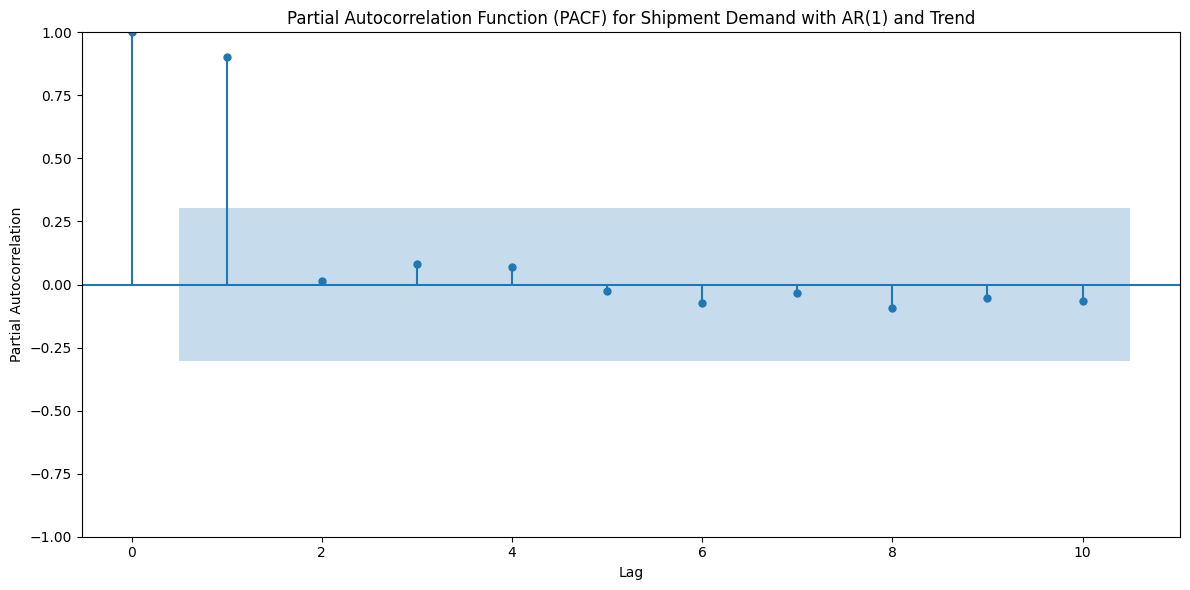

In [57]:
from statsmodels.graphics.tsaplots import plot_pacf

# Plotting the Partial Autocorrelation Function (PACF) for the demand data
fig, ax = plt.subplots(figsize=(12, 6))
plot_pacf(df_ar_trend['Demand'], ax=ax, lags=10, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF) for Shipment Demand with AR(1) and Trend')
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.tight_layout()
plt.show()

PACF suggest what that two AR lags might be approapiate, even though we generate the data with only one lag. This is happening by chance, but as we will see, the objective of this components is to unbiased the model by making errors non-correlated with each other, so lets move forward assuming two lagged components

In [58]:
# Creating a lag of the dependent variable (shipment demand)
df_ar_trend['LaggedDemand'] = df_ar_trend['Demand'].shift(1)
df_ar_trend['LaggedDemand_2'] = df_ar_trend['Demand'].shift(2)
df_ar_trend.dropna(inplace=True)  # Drop the first rows due to the lag

# Building the segmented regression model with lagged demand
X_ar_trend = df_ar_trend[['Time', 'Intervention', 'TimeAfterIntervention', 'LaggedDemand','LaggedDemand_2']]
X_ar_trend = sm.add_constant(X_ar_trend)
y_ar_trend = df_ar_trend['Demand']

model_ar_trend = sm.OLS(y_ar_trend, X_ar_trend).fit()

# Displaying regression results
model_ar_trend.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Demand   R-squared:                       0.979
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     321.1
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           1.38e-27
Time:                        17:08:38   Log-Likelihood:                -236.15
No. Observations:                  40   AIC:                             484.3
Df Residuals:                      34   BIC:                             494.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                  1011.7777    190.589      5.309      0.000     624.454    1399.101
Time                     48.4643     10.217      4.744      0.000      27.702      69.227
Intervention           -522.7596    108.785     -4.805      0.000    -743.837    -301.682
TimeAfterIntervention    37.1226     29.794      1.246      0.221     -23.426      97.671
LaggedDemand              0.2605      0.152      1.718      0.095      -0.048       0.569
LaggedDemand_2           -0.0632      0.153     -0.413      0.682      -0.374       0.248
==============================================================================
Omnibus:                        1.436   Durbin-Watson:                   2.201
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.035
Skew:                           0.394   Prob(JB):                        0.596
Kurtosis:                       2.961   Cond. No.                     4.43e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.43e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Let's break down the regression results for the AR(1) time series with a growing trend:

**Coefficients:**

- **Intercept:** At the start of the time series, with no intervention, no post-intervention time, and no lagged demand, the shipment demand is about 1010 units.

- **Time(trend):** For each passing month (pre-intervention), the demand increases by about 48 units. This coefficient is statistically significant (p-value < 0.001), indicating the presence of the growing trend.

- **Intervention:** At the point of intervention (price change), the demand drops by approximately 522 units. This effect is statistically significant (p-value < 0.001).

- **Time After Intervention (Change in trend slope):** After the intervention, for each subsequent month, the trend accelarates by around 37 units. However, this coefficient is not statistically significant at the 0.05 level (p-value = 0.082), implying that the post-intervention trend might not be different from the pre-intervention trend.

- **Lagged Demand:** None of the coefficient are stat sig even though we know that AR(1) is present in the data (p-value > 0.05).

- **Durbin-Watson:** The Durbin-Watson statistic is approximately 2.191, which suggests there's no significant auto-correlation in the residuals of the model, indicating that our inclusion of the lagged demand term has effectively captured the autocorrelation in the series even if not statistical significant.

**Notes:** The condition number is reported to be large, indicating potential multicollinearity or other numerical problems. This could be due to the inclusion of both "Time" and "TimeAfterIntervention" variables, or the inclusion of "Time" and the trend effect, which are closely related.

**Interpretation:**

The immediate drop in demand following the price change is statistically significant and is about 522.30 units. Having siad that, overall growth doesn't seems to have been impacted by this price change as evidence by the non-stat post intervention trend regression component.

## Conclusion

This notebook demonstrates the use of Interrupted Time Series Analysis (ITSA) for causal inference in time series data. Two scenarios are explored: a standard time series and one with autocorrelation plus a trend.

In both cases, the analysis captures the effect of a price change on shipment demand. The presence of autocorrelation in the second scenario is verified using the Durbin-Watson statistic and PACF plot. both the autocorrelation and trend is addressed in the regression model with lagged variables and trend variable.

Overall, ITSA effectively determines the impact of interventions in time series data, even amidst complexities like autocorrelation.